In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path_to_img = './bot/data/grbrt_spb/photos/photo_66@05-03-2022_21-42-17.jpg'
nfeatures = 1000

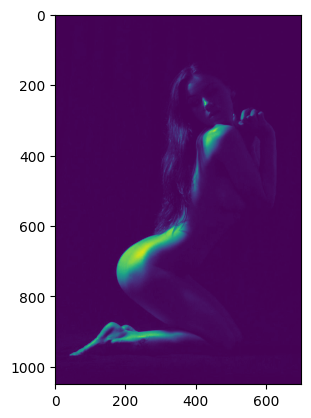

(1050, 700)

In [4]:
img = cv.imread(path_to_img, cv.IMREAD_GRAYSCALE)
plt.imshow(img),plt.show()
img.shape

In [5]:
width = int(img.shape[1] * 1.5)
height = int(img.shape[0] * 1.5)
scaled_img = cv.resize(img, (width, height))

In [6]:
# try filters (additional processing)

# Apply brightness adjustment
brightness_value = 50
scaled_img = np.clip(img + brightness_value, 0, 255).astype(np.uint8)

# Apply contrast adjustment
contrast_factor = 1.7
scaled_img = np.clip(contrast_factor * scaled_img, 0, 255).astype(np.uint8)

In [7]:
sift = cv.SIFT_create(nfeatures=1000, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)

In [8]:
kps1, desc1 = sift.detectAndCompute(scaled_img, None)
desc1.shape

(239, 128)

(91, 128)


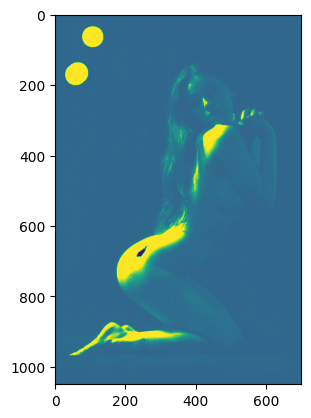

(<matplotlib.image.AxesImage at 0x7f59dab361a0>, None)

In [9]:
# add other key points or zeros
if desc1.shape[0] < nfeatures:
    size = 3
    corners = cv.goodFeaturesToTrack(scaled_img, maxCorners=1000, qualityLevel=0.01, minDistance=10, blockSize=size)
    # corners = corners.astype(int)
    keypoints = [cv.KeyPoint(x[0][1], x[0][0], size) for x in corners]
    cornes_kps, corner_desc = sift.compute(scaled_img, keypoints)
    
print( corner_desc.shape )

corners = np.intp(corners)
for i in corners[:3] :
    x,y = i.ravel()
    cv.circle(scaled_img, (x,y), 1, *(255, 60, 0), 2)

plt.imshow(scaled_img),plt.show()

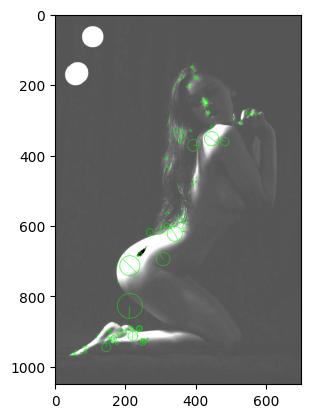

(<matplotlib.image.AxesImage at 0x7f59dab2e5c0>, None)

In [10]:
img_with_keypoints = cv.drawKeypoints(scaled_img, kps1, None, color=(0, 255, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_with_keypoints,),plt.show()

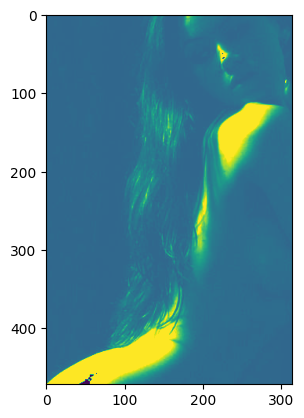

(<matplotlib.image.AxesImage at 0x7f5a140b0c70>, None)

In [11]:
crop_percent = 0.55
x, y = 200, 200
width = int(scaled_img.shape[1] * (1 - crop_percent) )
height = int(scaled_img.shape[0] * (1 - crop_percent) )

# Crop the region of interest from the image
cropped_image = scaled_img[y:y+height, x:x+width]

plt.imshow(cropped_image,),plt.show()

In [12]:
kps2, desc2 = sift.detectAndCompute(cropped_image, None)
desc2 = desc2[:nfeatures]
desc2.shape

(134, 128)

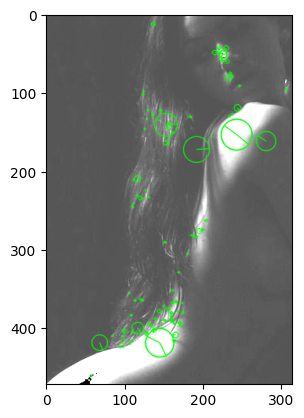

(<matplotlib.image.AxesImage at 0x7f59d827d300>, None)

In [13]:
img_with_keypoints = cv.drawKeypoints(cropped_image, kps2, None, color=(0, 255, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_with_keypoints,),plt.show()

In [14]:
bf = cv.BFMatcher()

In [15]:
match_percent = .6

In [16]:
matches = bf.knnMatch(desc1, desc2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < match_percent * n.distance:
        good_matches.append([m])
        

print("good matches: ", len( good_matches ), " all: ", len(matches) )

good matches:  131  all:  239


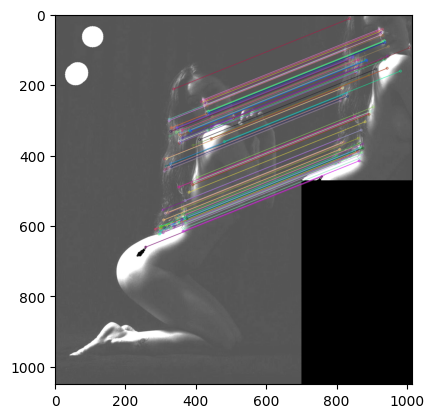

(<matplotlib.image.AxesImage at 0x7f59dccc76d0>, None)

In [17]:
img_match = cv.drawMatchesKnn(scaled_img, kps1, cropped_image, kps2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_match,),plt.show()

In [18]:
v_match = len(good_matches)/len(matches)

if desc1.shape[0] == desc2.shape[0]:
    print("Match persets: ", v_match,", Distanse: ", np.linalg.norm(desc1 - desc2))

if v_match > match_percent:
    print( True )
else:
    print( False )

False


In [19]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params, search_params)

In [20]:

matches = flann.knnMatch(desc1,desc2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < match_percent * n.distance:
        good_matches.append([m])
        matchesMask[i]=[1,0]

print("good matches: ", len( good_matches ), " all: ", len(matches) )

draw_params = dict(matchColor = (0,255,0), singlePointColor = (255,0,0),
                   matchesMask = matchesMask, flags = cv.DrawMatchesFlags_DEFAULT)

good matches:  262  all:  239


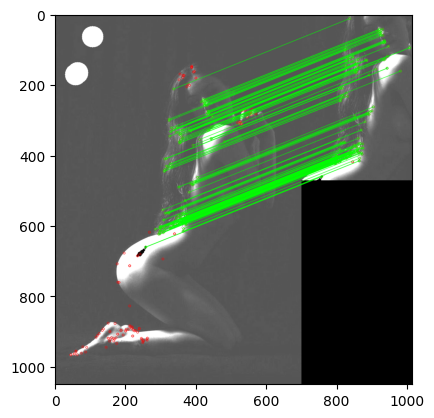

(<matplotlib.image.AxesImage at 0x7f59d82f5540>, None)

In [21]:
img_match = cv.drawMatchesKnn(scaled_img, kps1, cropped_image, kps2, matches, None, **draw_params)
plt.imshow(img_match,),plt.show()

In [23]:
v_match = len(good_matches)/len(matches)

if desc1.shape[0] == desc2.shape[0]:
    print("Match persets: ", v_match,", Distanse: ", np.linalg.norm(desc1 - desc2))

if v_match > match_percent:
    print( True )
else:
    print( False )

True
